# Задача классификации изображений


Стоит задача написать нейросеть для классификации изображений на  классов: Television, Sofas, Jeans, T-shirt и Other.

Для этого вначале подключим все необходимые библиотеки. Так же для удобства будем работать в текущей директории и скроем сообщения о предупреждениях:

In [1]:
## -*- coding: utf-8 -*-

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
from torchvision import datasets, transforms, models
from torchvision.transforms import v2
import os
import matplotlib.image as mpimg
import torch.nn as nn
import torch.nn.functional as F
import csv
import warnings 
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset
from skimage import io

os.chdir(os.getcwd())
warnings.filterwarnings('ignore')

C:\Users\Влад\AppData\Local\Temp\ipykernel_17272\4126517766.py:15: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Объявим класс для инициализации нашего датасета, основываясь на структуре используемых csv файлов

In [2]:
class ImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 1])
        image = io.imread(img_path)
        label = self.img_labels.iloc[idx, 0]
        if self.transform:
            image = self.transform(image)
        return image, label

Для корректоной работы нейросети, изображения должны быть в одном формате, соответственно приведем все изображения к размеру 150x150 и переведем их в тензоры. 
С вышеуказанными изменениями получем два датасета. Первый - с 4мя классами Television, Sofas, Jeans, T-shirt и второй, включающий в себя изображения для класса other.

In [3]:
transform1 = transforms.Compose([         
            v2.ToTensor(),
            v2.Resize([150, 150])])

train_data = ImageDataset(annotations_file = 'table.csv', img_dir = 'test_data', transform=transform1)
train_dataD = ImageDataset(annotations_file = 'other3.csv', img_dir = 'test_data', transform=transform1)

Объявим нашу модель:

In [4]:
class ConvNet(nn.Module):
    def __init__(self, exits_num):
        super().__init__()
        #150*150*3
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=(3,3))
        self.pool1 = nn.MaxPool2d(kernel_size=(2,2))
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=9, kernel_size=(3,3)) 
        self.pool2 = nn.MaxPool2d(kernel_size=(2,2))
        self.conv3 = nn.Conv2d(in_channels=9, out_channels=12, kernel_size=(3,3))
        self.pool3 = nn.MaxPool2d(kernel_size=(2,2))
        self.flatten = nn.Flatten()
        self.drop = nn.Dropout(0.5)
        self.fc1 = nn.Linear(12*17*17, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, exits_num)

    
    def forward(self, x):

        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)

        x = self.flatten(x)
        x = self.drop(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x), dim = 1)
        return x

Объявим функцию для оценки работы нашей модели:

In [5]:
def evaluate(model, dataloader, loss_fn):
    
    losses = []

    num_correct = 0
    num_elements = 0

    for i, batch in enumerate(dataloader):
        
        X_batch, y_batch = batch
        num_elements += y_batch.size(0)
        with torch.no_grad():
            logits = model(X_batch.to(device))
            loss = loss_fn(logits, y_batch.to(device))
            losses.append(loss.item())
            
            y_pred = torch.argmax(logits, dim=1).cpu()
            
            num_correct += torch.sum(y_pred == y_batch)
    accuracy = num_correct / num_elements
            
    return accuracy, np.mean(losses)

Объявим функцию для обучения нашей сети. В ней реализован механизм отслеживания точности и потерь на валидационной выборке. При этом реализуем механизм сохраненния модели с наименьшим значением потерь на валидации, чтобы избежать переобучения:

In [6]:
def train(model, loss_fn, optimizer, n_epoch, load, val):
    global m, number, minloss
    num_iter = 0
    for epoch in range(n_epoch):

        model.train(True)

        running_losses = []
        running_accuracies = []
        for i, batch in enumerate(load):
            X_batch, y_batch = batch
            logits = model(X_batch.to(device))
            
            loss = loss_fn(logits, y_batch.to(device))
            running_losses.append(loss.item())

            loss.backward()
            optimizer.step() 
            optimizer.zero_grad() 
            model_answers = torch.argmax(logits, dim=1)
            train_accuracy = torch.sum(y_batch == model_answers.cpu()) / len(y_batch)
            running_accuracies.append(train_accuracy)
            num_iter += 1

        val_accuracy, val_loss = evaluate(model, val, loss_fn=loss_fn)
            
        model.train(False)
        accuracy = (sum(running_accuracies) * 100 / len(running_accuracies)).numpy()
        losst = sum(running_losses) * 100 / len(running_losses)
        print("Epoch:", str(epoch+1) + ', model', number)
        print("Train | accuracy:", accuracy, ", loss:", losst)
        print("Validation | accuracy:", val_accuracy.numpy() * 100, ", loss:", val_loss * 100)
        m[number][0] += [accuracy]
        m[number][1] += [losst]
        m[number][2] += [val_accuracy.numpy() * 100]
        m[number][3] += [val_loss * 100]
        print("__________________________________________________________")
        if val_loss <= minloss:
            torch.save(model.state_dict(), './model.pt')
            minloss = val_loss
        
    return model

Теперь рассмотрим возможные решения добавления класса 'other'. Рассмотрим два способа и выберем наилучший. Первый способ заключается в обучении модели сразу на пяти классах, второй позволяет модели обучиться на четрыех классах и только затем замораживаются все слои, кроме последнего, а в последний добавляется пятый выход.

## Первый способ

Предполагается, что модель сама сможет понять, что в изображениях датасета other мало общего и будет основываться только на первых четырех классах

Поделим датасет на обучающий, валидационный и тестовый:

In [9]:
train_sizeD = int(len(train_dataD) * 0.70)
val_sizeD = int(len(train_dataD) * 0.20)
test_sizeD = len(train_dataD) - train_sizeD - val_sizeD
train_data1D, val_data1D, test_data1D = torch.utils.data.random_split(train_dataD, [train_sizeD, val_sizeD, test_sizeD])
train_data2D, val_data2D, test_data2D = torch.utils.data.random_split(train_dataD, [train_sizeD, val_sizeD, test_sizeD])
train_data3D, val_data3D, test_data3D = torch.utils.data.random_split(train_dataD, [train_sizeD, val_sizeD, test_sizeD])
train_loaderD = [torch.utils.data.DataLoader(train_data1D, batch_size=20, shuffle=True), torch.utils.data.DataLoader(train_data2D, batch_size=20, shuffle=True), torch.utils.data.DataLoader(train_data3D, batch_size=20, shuffle=True)]
val_loderD = [torch.utils.data.DataLoader(val_data1D, batch_size=20, shuffle=True), torch.utils.data.DataLoader(val_data2D, batch_size=20, shuffle=True), torch.utils.data.DataLoader(val_data3D, batch_size=20, shuffle=True)]
test_loaderD = [torch.utils.data.DataLoader(test_data1D, batch_size=20, shuffle=True), torch.utils.data.DataLoader(test_data2D, batch_size=20, shuffle=True), torch.utils.data.DataLoader(test_data3D, batch_size=20, shuffle=True)]

Создадим модель, перенесем вычисления на gpu и будем теренровать её 20 эпох (такое значение избыточно, но в обучении есть защита от переобучения) 3 раза для большей уверенности и сбора статистики.

In [10]:
minloss = 200
m = [[[], [], [], []], [[], [], [], []], [[], [], [], []]]
train_accuracy = []
test_accuracy = []
for number in range (0, 3):
    print("Model " + str(number) + ":")
    model = ConvNet(5)
    loss_fn = torch.nn.CrossEntropyLoss()
    learning_rate = 1e-3
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model = train(model, loss_fn, optimizer, 20, train_loaderD[number], val_loderD[number])
    trainT, _ = evaluate(model, train_loaderD[number], loss_fn)
    testT, _ = evaluate(model, test_loaderD[number], loss_fn)
    train_accuracy += [trainT]
    test_accuracy += [testT]

Model 0:
Epoch: 1, model 0
Train | accuracy: 33.263893 , loss: 149.62606489658356
Validation | accuracy: 65.78947305679321 , loss: 115.51943023999532
__________________________________________________________
Epoch: 2, model 0
Train | accuracy: 67.91667 , loss: 82.24079802632332
Validation | accuracy: 78.0701756477356 , loss: 68.27782144149145
__________________________________________________________
Epoch: 3, model 0
Train | accuracy: 79.68055 , loss: 57.78903067111969
Validation | accuracy: 81.14035129547119 , loss: 52.46693044900894
__________________________________________________________
Epoch: 4, model 0
Train | accuracy: 85.34722 , loss: 42.06610573455691
Validation | accuracy: 81.14035129547119 , loss: 60.20520503322283
__________________________________________________________
Epoch: 5, model 0
Train | accuracy: 85.70833 , loss: 36.78382236510515
Validation | accuracy: 84.64912176132202 , loss: 49.74416643381119
__________________________________________________________
Epoc

Пострим графики точности и потерь:

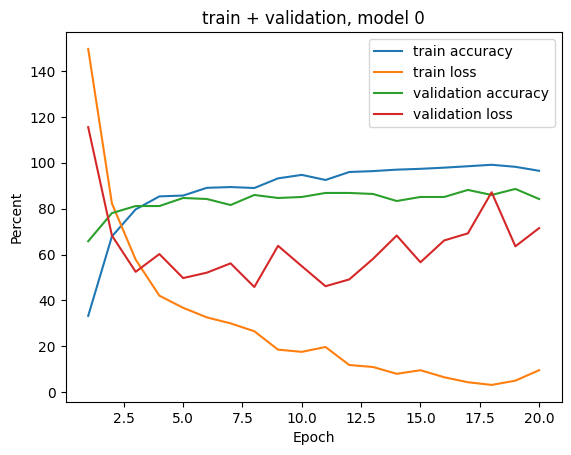

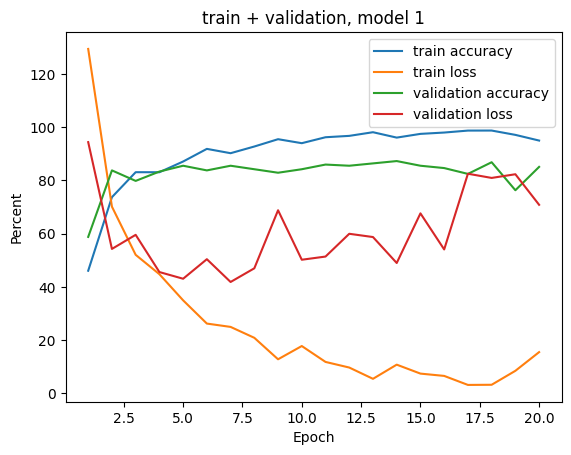

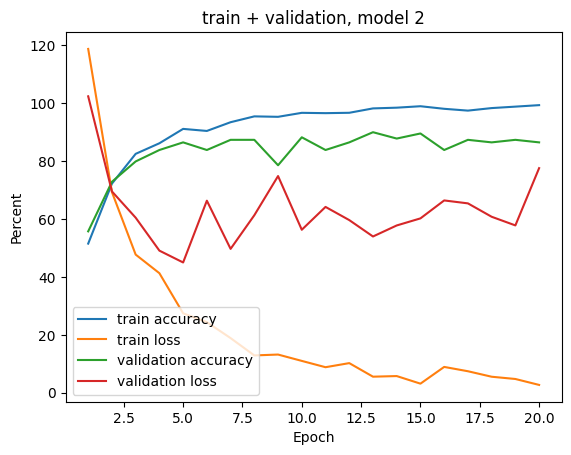

In [11]:
x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
for i in range (0, 3):
    plt.plot(x, m[i][0], label='train accuracy')
    plt.plot(x, m[i][1], label='train loss')
    plt.plot(x, m[i][2], label='validation accuracy')
    plt.plot(x, m[i][3], label='validation loss')
    plt.title('train + validation, model ' + str(i))
    plt.xlabel('Epoch')
    plt.ylabel('Percent')
    plt.legend()

    plt.show()

Можно заметить, что результат довольно плохой. Минимальное значение потерь на трех валидационных выборках находилось в окрестности сорока процентов, что делает результаты данной модели недостоверными.

Оценим результаты обучения модели:

In [12]:
for i in range(0, 3):
    print("Model " + str(i) + ":")
    print('Train accuracy:', train_accuracy[i].numpy())
    print('Test accuracy:', test_accuracy[i].numpy())
    print("__________________________________________________________")

Model 0:
Train accuracy: 0.9899749
Test accuracy: 0.88596493
__________________________________________________________
Model 1:
Train accuracy: 0.99122804
Test accuracy: 0.8333333
__________________________________________________________
Model 2:
Train accuracy: 0.9962406
Test accuracy: 0.88596493
__________________________________________________________


Точность на тестовых выборках не превышает 90%, такой результат является неудовлетворительным.

## Второй способ

Поделим оба датасета (для обучения на 4 классах и для дообучения на 5 классах) на обучающий, валидационный и тестовый:

In [52]:
train_size = int(len(train_data) * 0.80)
val_size = len(train_data) - train_size
train_data1, val_data1 = torch.utils.data.random_split(train_data, [train_size, val_size])
train_data2, val_data2 = torch.utils.data.random_split(train_data, [train_size, val_size])
train_data3, val_data3 = torch.utils.data.random_split(train_data, [train_size, val_size])
train_loader = [torch.utils.data.DataLoader(train_data1, batch_size=20, shuffle=True), torch.utils.data.DataLoader(train_data2, batch_size=20, shuffle=True), torch.utils.data.DataLoader(train_data3, batch_size=20, shuffle=True)]
val_loder = [torch.utils.data.DataLoader(val_data1, batch_size=20, shuffle=True), torch.utils.data.DataLoader(val_data2, batch_size=20, shuffle=True), torch.utils.data.DataLoader(val_data3, batch_size=20, shuffle=True)]

train_sizeD = int(len(train_dataD) * 0.70)
val_sizeD = int(len(train_dataD) * 0.20)
test_sizeD = len(train_dataD) - train_sizeD - val_sizeD
train_data1D, val_data1D, test_data1D = torch.utils.data.random_split(train_dataD, [train_sizeD, val_sizeD, test_sizeD])
train_data2D, val_data2D, test_data2D = torch.utils.data.random_split(train_dataD, [train_sizeD, val_sizeD, test_sizeD])
train_data3D, val_data3D, test_data3D = torch.utils.data.random_split(train_dataD, [train_sizeD, val_sizeD, test_sizeD])
train_loaderD = [torch.utils.data.DataLoader(train_data1D, batch_size=20, shuffle=True), torch.utils.data.DataLoader(train_data2D, batch_size=20, shuffle=True), torch.utils.data.DataLoader(train_data3D, batch_size=20, shuffle=True)]
val_loderD = [torch.utils.data.DataLoader(val_data1D, batch_size=20, shuffle=True), torch.utils.data.DataLoader(val_data2D, batch_size=20, shuffle=True), torch.utils.data.DataLoader(val_data3D, batch_size=20, shuffle=True)]
test_loaderD = [torch.utils.data.DataLoader(test_data1D, batch_size=20, shuffle=True), torch.utils.data.DataLoader(test_data2D, batch_size=20, shuffle=True), torch.utils.data.DataLoader(test_data3D, batch_size=20, shuffle=True)]


Следующая функция служит для реализации дообучения нашей сети. Последний слой заменяется, а некоторое количество предыдущих слоев замораживаются, что позволяет сохранить веса, полученные при первичном обучении:

In [44]:
def create_model(model, num_freeze_layers, num_out_classes):
    model.fc3 = nn.Linear(512, 5)
    for i, layer in enumerate(model.children()):
        if i < num_freeze_layers:
            for param in layer.parameters():
                param.requires_grad = False

    return model

Создадим модель, перенесем вычисления на gpu и будем теренровать её 20 эпох (такое значение избыточно, но в обучении есть защита от переобучения)

In [57]:
minloss = 200
m = [[[], [], [], []], [[], [], [], []], [[], [], [], []]]
for number in range (0, 3):
    print("Model " + str(number) + ":")
    model = ConvNet(4)
    loss_fn = torch.nn.CrossEntropyLoss()
    learning_rate = 1e-3
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model = train(model, loss_fn, optimizer, 20, train_loader[number], val_loder[number])

Model 0:


Epoch: 1, model 0
Train | accuracy: 54.516132 , loss: 105.19985546988826
Validation | accuracy: 84.10596251487732 , loss: 53.00981290638447
__________________________________________________________
Epoch: 2, model 0
Train | accuracy: 86.7742 , loss: 37.77037914241514
Validation | accuracy: 89.40397500991821 , loss: 47.37341534346342
__________________________________________________________
Epoch: 3, model 0
Train | accuracy: 90.32258 , loss: 27.313509775746255
Validation | accuracy: 88.7417197227478 , loss: 44.1417058929801
__________________________________________________________
Epoch: 4, model 0
Train | accuracy: 94.03227 , loss: 19.519959330078095
Validation | accuracy: 93.37748289108276 , loss: 28.959895251318812
__________________________________________________________
Epoch: 5, model 0
Train | accuracy: 94.67743 , loss: 14.854026669936795
Validation | accuracy: 93.37748289108276 , loss: 34.632202284410596
__________________________________________________________
Epoch: 6, m

Посмотрим на график точности и потерь для тестовой и валидационной выборок. 

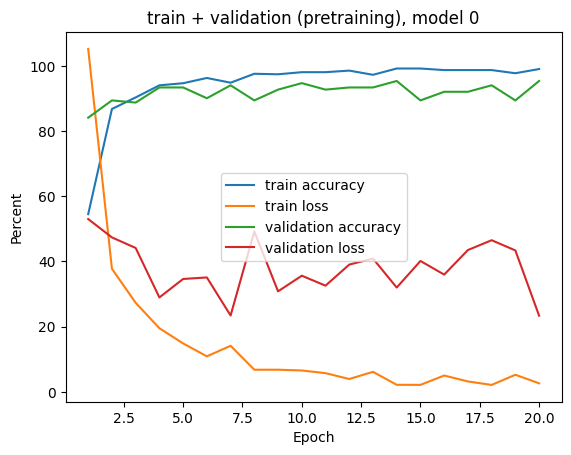

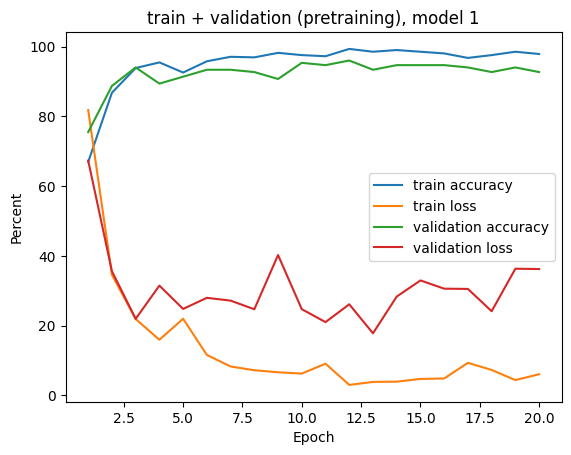

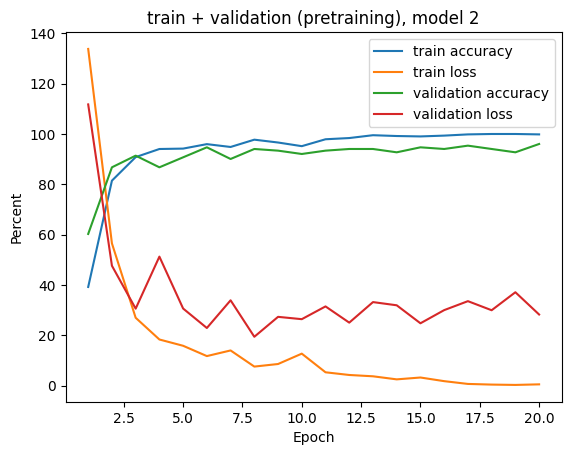

In [58]:
x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
for i in range (0, 3):
    plt.plot(x, m[i][0], label='train accuracy')
    plt.plot(x, m[i][1], label='train loss')
    plt.plot(x, m[i][2], label='validation accuracy')
    plt.plot(x, m[i][3], label='validation loss')
    plt.title('train + validation (pretraining), model ' + str(i))
    plt.xlabel('Epoch')
    plt.ylabel('Percent')
    plt.legend()

    plt.show()

Заметим, что во время обучения значение потерь на валидации постоянно сильно меняется, в то время как точность остается практически неизменной, поэтому необходимо сохранить модель с наименьшим значением потерь, для получения наилучшего результата.

Заморозим все слои кроме последнего, заменив его на слой с 5ью выходами. Дообучим модель на датасете с 5ью классами:

In [96]:
m = [[[], [], [], []], [[], [], [], []], [[], [], [], []]]
minloss = 120
model.load_state_dict(torch.load('model.pt'))
model = create_model(model, 3, 5)
train_accuracy = []
test_accuracy = []

torch.save(model.state_dict(), './test.pt')

for number in range (0, 3):
    model.load_state_dict(torch.load('test.pt'))
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    model = train(model, loss_fn, optimizer, 20, train_loaderD[number], val_loderD[number])
    trainT, _ = evaluate(model, train_loaderD[number], loss_fn)
    testT, _ = evaluate(model, test_loaderD[number], loss_fn)
    train_accuracy += [trainT]
    test_accuracy += [testT]

Epoch: 1, model 0
Train | accuracy: 94.25 , loss: 23.44952941472002
Validation | accuracy: 88.59649300575256 , loss: 59.622182324528694
__________________________________________________________
Epoch: 2, model 0
Train | accuracy: 100.0 , loss: 0.36049837378527627
Validation | accuracy: 87.71929740905762 , loss: 78.34131607378367
__________________________________________________________
Epoch: 3, model 0
Train | accuracy: 100.0 , loss: 0.1909364912626188
Validation | accuracy: 85.52631735801697 , loss: 72.27706406265497
__________________________________________________________
Epoch: 4, model 0
Train | accuracy: 99.75001 , loss: 0.6217710289584488
Validation | accuracy: 85.52631735801697 , loss: 115.3620923558871
__________________________________________________________
Epoch: 5, model 0
Train | accuracy: 99.12501 , loss: 2.465617929256041
Validation | accuracy: 84.21052694320679 , loss: 97.80283396442732
__________________________________________________________
Epoch: 6, model 0
T

Рассмотрим графики дообученых нейросетей:

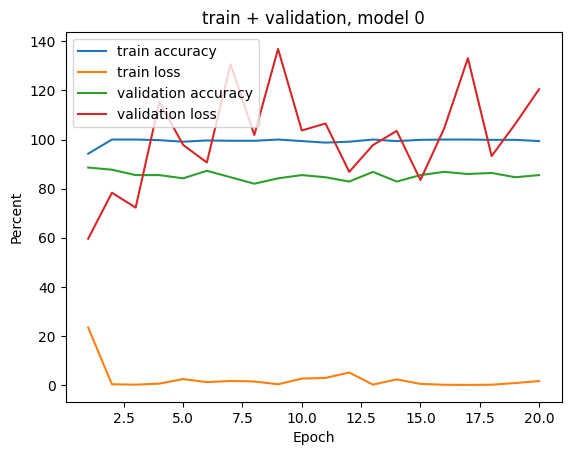

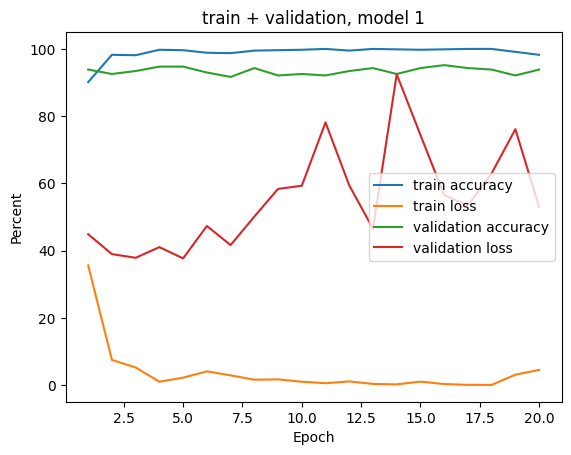

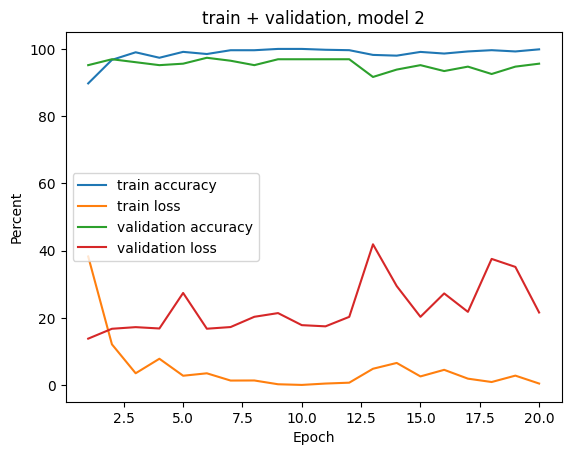

In [97]:
x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
for i in range (0, 3):
    plt.plot(x, m[i][0], label='train accuracy')
    plt.plot(x, m[i][1], label='train loss')
    plt.plot(x, m[i][2], label='validation accuracy')
    plt.plot(x, m[i][3], label='validation loss')
    plt.title('train + validation, model ' + str(i))
    plt.xlabel('Epoch')
    plt.ylabel('Percent')
    plt.legend()

    plt.show()

Посморим итоговые результаты на обучающем и тестовом датасетах:

In [98]:
for i in range(0, 3):
    print("Model " + str(i) + ":")
    print('Train accuracy:', train_accuracy[i].numpy())
    print('Test accuracy:', test_accuracy[i].numpy())
    print("__________________________________________________________")

Model 0:
Train accuracy: 1.0
Test accuracy: 0.8596491
__________________________________________________________
Model 1:
Train accuracy: 1.0
Test accuracy: 0.9122807
__________________________________________________________
Model 2:
Train accuracy: 1.0
Test accuracy: 0.9736842
__________________________________________________________


Заметим, что модель выдала три разных результата на трех разных датасетах (как итоговые результаты, так и сам процесс обучения очень отличаются). Это связано с плохой нормализацией этого датасета (он делится случайно и может оказаться, что изображений одного класса много, а другого мало). Однако можно заметить наличие хорошего результата (последний).

## Сравнение способов

Итак, в обоих способах есть свои недостатки, но в отличии от первого способа, в равных условиях второй способен показывать хорошие результаты. Поэтому нормализуем датасет и посмотрим на полученные результаты. В качестве эксперимента возьмем датасет, где изображений класса other столько же, сколько и в каждом из других классов и где их как во всех 4ех класса в сумме.

## Итоговый способ

Напишем функцию обработки и загрузим датасеты, отсортированные по именным папкам. Таким образом в итоговых обучающих, валидационных и тестовых датасетах будет равное количество изображений из каждого класса:

In [19]:
def createdata(annotation, dirname, isval):
    global train_data, val_data, test_data
    train_data_temp = ImageDataset(annotations_file=annotation, img_dir=dirname, transform=transform1)
    if isval == True:
        train_size_temp = int(len(train_data_temp) * 0.70)
        val_size_temp = int(len(train_data_temp) * 0.20)
        test_size_temp = len(train_data_temp) - train_size_temp - val_size_temp
        train_data_temp, val_data_temp, test_data_temp = torch.utils.data.random_split(train_data_temp, [train_size_temp, val_size_temp, test_size_temp])
    else:
        train_size_temp = int(len(train_data_temp) * 0.80)
        test_size_temp = len(train_data_temp) - train_size_temp
        train_data_temp, test_data_temp = torch.utils.data.random_split(train_data_temp, [train_size_temp, test_size_temp])
    if train_data == 0:
        train_data = train_data_temp
        test_data = test_data_temp
        if isval:
            val_data = val_data_temp
    else:
        train_data += train_data_temp
        test_data += test_data_temp
        if isval:
            if val_data == 0:
                val_data = val_data_temp

In [31]:

train_data = 0
val_data = 0
test_data = 0
createdata('dataset/jeans.csv', 'dataset/dataset_equal/jeans', False)
createdata('dataset/tshirt.csv', 'dataset/dataset_equal/tshirt', False)
createdata('dataset/sofa.csv', 'dataset/dataset_equal/sofa', False)
createdata('dataset/tv.csv', 'dataset/dataset_equal/tv', False)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=20, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=20, shuffle=False)

In [32]:
train_loaderD = torch.utils.data.DataLoader(train_data, batch_size=20, shuffle=True)
val_loaderD = torch.utils.data.DataLoader(val_data, batch_size=20, shuffle=True)
test_loaderD = torch.utils.data.DataLoader(test_data, batch_size=20, shuffle=False)

Обучим модель на 20 эпохах и построим график точности и потерь:

In [33]:
minloss = 200
m = [[[], [], [], []]]
number = 0
model = ConvNet(4)
loss_fn = torch.nn.CrossEntropyLoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model = train(model, loss_fn, optimizer, 20, train_loader, test_loader)

Epoch: 1, model 0
Train | accuracy: 32.812496 , loss: 137.37415224313736
Validation | accuracy: 55.000001192092896 , loss: 118.64025890827179
__________________________________________________________
Epoch: 2, model 0
Train | accuracy: 78.43751 , loss: 66.41478198580444
Validation | accuracy: 84.375 , loss: 47.50760471797548
__________________________________________________________
Epoch: 3, model 0
Train | accuracy: 85.62501 , loss: 41.725504072383046
Validation | accuracy: 90.625 , loss: 22.5775430444628
__________________________________________________________
Epoch: 4, model 0
Train | accuracy: 91.95312 , loss: 24.118855403503403
Validation | accuracy: 88.12500238418579 , loss: 37.4915367923677
__________________________________________________________
Epoch: 5, model 0
Train | accuracy: 93.39844 , loss: 18.188218923751265
Validation | accuracy: 90.625 , loss: 23.89857361849863
__________________________________________________________
Epoch: 6, model 0
Train | accuracy: 95.4687

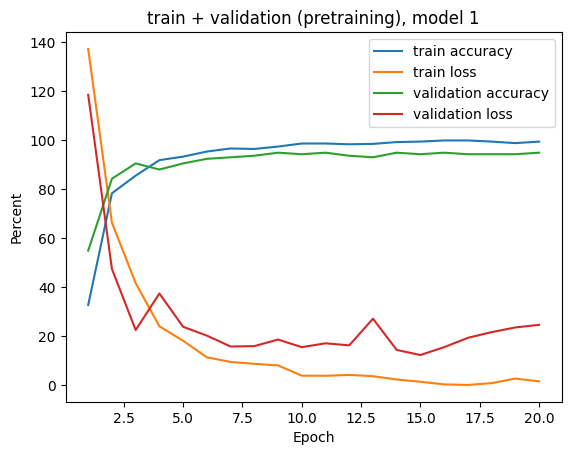

In [34]:
x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
plt.plot(x, m[0][0], label='train accuracy')
plt.plot(x, m[0][1], label='train loss')
plt.plot(x, m[0][2], label='validation accuracy')
plt.plot(x, m[0][3], label='validation loss')
plt.title('train + validation (pretraining), model ' + str(i))
plt.xlabel('Epoch')
plt.ylabel('Percent')
plt.legend()

plt.show()

Мы получили модель обученную на классификацию на 4 класса. На нормализованных данных модель показала себя очень хорошо. Сохраним модель и дообучим ее на разном количестве элемнтов в датасете other:

In [54]:
torch.save(model.state_dict(), './model_final.pt')
model.load_state_dict(torch.load('model_final.pt'))


<All keys matched successfully>

Рассмотрим датасет other на 199 изображений:

In [37]:
train_data = 0
val_data = 0
test_data = 0
createdata('dataset/jeans.csv', 'dataset/dataset_equal/jeans', True)
createdata('dataset/tshirt.csv', 'dataset/dataset_equal/tshirt', True)
createdata('dataset/sofa.csv', 'dataset/dataset_equal/sofa', True)
createdata('dataset/tv.csv', 'dataset/dataset_equal/tv', True)
createdata('dataset/other.csv', 'dataset/dataset_equal/other', True)
train_loaderD = torch.utils.data.DataLoader(train_data, batch_size=20, shuffle=True)
val_loaderD = torch.utils.data.DataLoader(val_data, batch_size=20, shuffle=True)
test_loaderD = torch.utils.data.DataLoader(test_data, batch_size=20, shuffle=False)

In [55]:
m = [[[], [], [], []]]
minloss = 200
model = create_model(model, 3, 5)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
model = train(model, loss_fn, optimizer, 20, train_loaderD, val_loaderD)

Epoch: 1, model 0
Train | accuracy: 76.80953 , loss: 56.41026939664568
Validation | accuracy: 94.87179517745972 , loss: 12.81721144914627
__________________________________________________________
Epoch: 2, model 0
Train | accuracy: 87.571434 , loss: 29.835940854890005
Validation | accuracy: 94.87179517745972 , loss: 8.787756273522973
__________________________________________________________
Epoch: 3, model 0
Train | accuracy: 90.76191 , loss: 21.500076523848943
Validation | accuracy: 94.87179517745972 , loss: 7.742522656917572
__________________________________________________________
Epoch: 4, model 0
Train | accuracy: 92.4762 , loss: 18.215628995427064
Validation | accuracy: 97.43589758872986 , loss: 4.177207313477993
__________________________________________________________
Epoch: 5, model 0
Train | accuracy: 93.80953 , loss: 14.543734192848206
Validation | accuracy: 94.87179517745972 , loss: 7.693185505922884
__________________________________________________________
Epoch: 6, m

Рассмотрим график точности и потери на тренировочной и валидационной выборках:

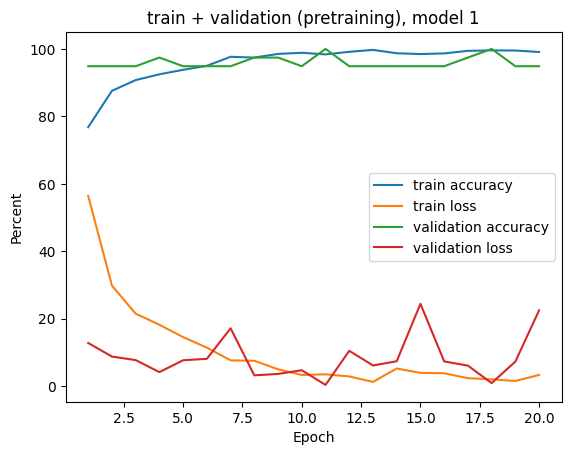

In [56]:
x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
plt.plot(x, m[0][0], label='train accuracy')
plt.plot(x, m[0][1], label='train loss')
plt.plot(x, m[0][2], label='validation accuracy')
plt.plot(x, m[0][3], label='validation loss')
plt.title('train + validation (pretraining), model ' + str(i))
plt.xlabel('Epoch')
plt.ylabel('Percent')
plt.legend()

plt.show()

Как видно, модель держит очень маленькое значение потери на валидации, также точность модели очень высокая.

In [62]:
model.load_state_dict(torch.load('model.pt'))
train_accuracy, _ = evaluate(model, train_loaderD, loss_fn)
print('Train accuracy:', train_accuracy.numpy())

test_accuracy, _ = evaluate(model, test_loaderD, loss_fn)
print('Test accuracy:', test_accuracy.numpy())

Train accuracy: 0.99568343
Test accuracy: 1.0


Значения итоговой точности очень хорошие, что позволяет нам использовать именно эту модель.


Посмотрим модель с значением элементов класса other равным сумме элементов других классов (199 * 4 = 996):

In [64]:
model.load_state_dict(torch.load('model_final.pt'))
train_data = 0
val_data = 0
test_data = 0
createdata('dataset/jeans.csv', 'dataset/dataset_equal/jeans', True)
createdata('dataset/tshirt.csv', 'dataset/dataset_equal/tshirt', True)
createdata('dataset/sofa.csv', 'dataset/dataset_equal/sofa', True)
createdata('dataset/tv.csv', 'dataset/dataset_equal/tv', True)
createdata('dataset/otherplus.csv', 'dataset/dataset_equal/otherplus', True)
train_loaderD = torch.utils.data.DataLoader(train_data, batch_size=20, shuffle=True)
val_loaderD = torch.utils.data.DataLoader(val_data, batch_size=20, shuffle=True)
test_loaderD = torch.utils.data.DataLoader(test_data, batch_size=20, shuffle=False)

In [65]:
m = [[[], [], [], []]]
minloss = 200
model = create_model(model, 3, 5)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
model = train(model, loss_fn, optimizer, 20, train_loaderD, val_loaderD)

Epoch: 1, model 0
Train | accuracy: 79.00488 , loss: 55.70573390476287
Validation | accuracy: 92.30769276618958 , loss: 32.04943984746933
__________________________________________________________
Epoch: 2, model 0
Train | accuracy: 87.85715 , loss: 29.47432700367201
Validation | accuracy: 87.17948794364929 , loss: 51.388537138700485
__________________________________________________________
Epoch: 3, model 0
Train | accuracy: 91.26986 , loss: 21.890534096885297
Validation | accuracy: 89.74359035491943 , loss: 37.41697818040848
__________________________________________________________
Epoch: 4, model 0
Train | accuracy: 93.766815 , loss: 17.668343702005963
Validation | accuracy: 89.74359035491943 , loss: 49.01233371347189
__________________________________________________________
Epoch: 5, model 0
Train | accuracy: 93.88891 , loss: 15.274315380624362
Validation | accuracy: 87.17948794364929 , loss: 54.68322038650513
__________________________________________________________
Epoch: 6, 

Посмотрим тот же самый график, но уже для этой модели:

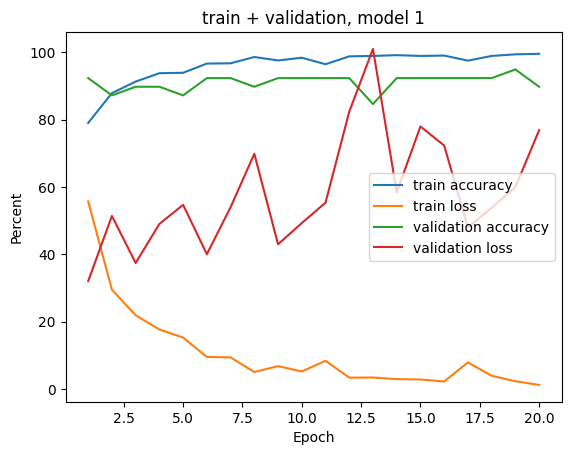

In [66]:
x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
plt.plot(x, m[0][0], label='train accuracy')
plt.plot(x, m[0][1], label='train loss')
plt.plot(x, m[0][2], label='validation accuracy')
plt.plot(x, m[0][3], label='validation loss')
plt.title('train + validation, model ' + str(i))
plt.xlabel('Epoch')
plt.ylabel('Percent')
plt.legend()

plt.show()

Можно увидеть очень высокое значение потерь на валидации на протяжении всего обучения, что говорит о плохом качестве обучения.

In [67]:
model.load_state_dict(torch.load('model.pt'))
train_accuracy, _ = evaluate(model, train_loaderD, loss_fn)
print('Train accuracy:', train_accuracy.numpy())

test_accuracy, _ = evaluate(model, test_loaderD, loss_fn)
print('Test accuracy:', test_accuracy.numpy())

Train accuracy: 0.8882682
Test accuracy: 0.88586956


Точность данной модели также сильно уступает предыдущей.

## Итоги

С помощью различный экспериментов была найдена модель, стабильно показывающая хорошие результаты. Это было достигнуто с помощью дообучения модели для классификации на 4 класса с заменой последнего слоя на слой с 5ью выходами и заморозкой остальных слоев. Так же была доказана важность нормализации датасета и борьбы с переобучением.